# Der eindimensionale Kalman-Filter, Teil 1 Grundlagen
1.3.2019, S. Mack

In [1]:
# display plots inside this notebook
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np

Was bisher geschah:
1. In den ersten beiden Notebooks wurde der g-h-Filter behandelt. Mit ihm wurde der auch für den Kalman-Filter grundlegende Filteralgorithmus in Form der Iteration aus Vorhersage und Korrektur eingeführt.  
2. In den beiden Notebooks zum diskreten Bayes-Filter wurde die Bayes-Wahrscheinlichkeitsrechnung eingeführt. Zudem wurden die mathematischen Rechenwege der Filteriteration entwickelt: Die Faltung für die Vorhersage und die elementweise Vektormultiplikation für die Korrektur.  
3. Im Notebook zur Gaußschen Wahrscheinlichkeitsrechnung wurde aus der diskreten, multimodalen Bayes-Welt in die unimodale, kontinuierliche Gauß-Welt gewechselt: Für eine typische Filteraufgabe von Sensormesswerten ist die Gaußsche Wahrscheinlichkeitsrechnung besser geeignet. Die wesentlichen Eigenschaften von Gaußverteilungen sowie grundlegende Rechenvorschriften dazu wurden vorgestellt.  

> Nun ist es soweit, den **Bayes-Filter mit Gaußverteilungen zu kombinieren**: Nichts Anderes ist ein Kalman-Filter.

In diesem Teil wird auschließlich der eindimensionale Kalman-Filter behandelt: Es geht dabei nur um *eine* einzelne Zustandsgrößt wie z.B. der Abstand, welche "getrackt" oder anders gesagt "gefiltert" werden soll.

## Gedankenexperiment

Genau so wie im Kapitel zum Bayes-Filter soll die Position eines Roboterfahrzeugs in einem langen, dieses Mal geraden Flur "getrackt" werden. Nur gibt es jetzt keine Türsensoren und auch keinen Bewegungssensor.   
Die Position des Fahrzeugs im Flur wird über einen Abstandssensor gemessen. Da der Flur gerade ist, wird beispielsweise ein Lidarsensor am Anfang des Flurs platziert, der das Roboterfahrzeug antastet und so dessen Position misst.  

Dieser Abstandssensor besitzt eine zufällige Messunsicherheit. Die Messwerte streuen gaußförmig um den wahren Wert.

### Annahme als Gaußverteilung

Anders als beim Bayes-Filter ist die Annahme der Fahrzeugposition nicht mehr ein Histogramm. Die angenommene Fahrzeugposition ist jetzt eine Gaußverteilung.  
**Beispiel:** Angenommen, das Fahrzeug befindet sich in einem Abstand von 10 m. Diese Annahme hat aber eine Unsicherheit von $\pm$ 1 m bezogen auf ein Vertrauensniveau von 68 %.  Dies heißt nichts Anderes, dass die Wahrscheinlichkeitsverteilung des Fahrzeugabstands eine Gaußverteilung mit Erwartungswert 10 und Varianz 1 m² ist: Mathematisch wird diese unsichere Position über $\mathcal{N}(10,\, 1)$ ausgedrückt. Die entsprechende Wahrscheinlichkeitsverteilung ist in folgendem Plot dargestellt:

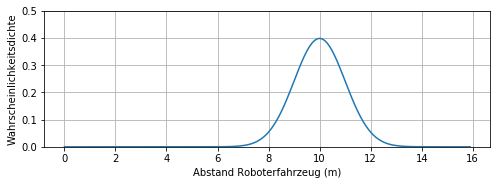

In [2]:
from scipy.stats import norm
x = np.arange(0,16,0.1)
mu = 10
sigma = 1
pdf_gauss = norm.pdf(x,mu,sigma)

fig, ax = plt.subplots(figsize=(8,2.5))
ax.plot(x,pdf_gauss)
ax.set_xlabel('Abstand Roboterfahrzeug (m)')
ax.set_ylabel('Wahrscheinlichkeitsdichte')
ax.set_ylim(0,0.5)
ax.grid()

Im nächsten Plot sind 500 simulierte Abstandsmesswerte für  $\mathcal N(10, 1)$ dargestellt. So würde eine Abfolge von Sensormessdaten aussehen, falls das Fahrzeug bewegungslos an der Position 10 m steht:

Mittelwert Abstandsmesswerte 9.979


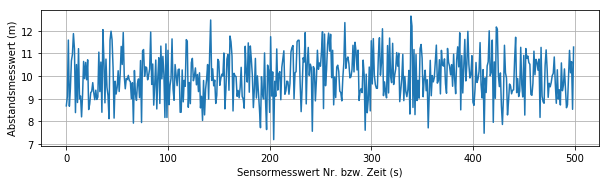

In [3]:
#from numpy.random import randn
import matplotlib.pyplot as plt

xs = range(500)
ys = np.random.randn(500)*1. + 10.
fig, ax = plt.subplots(figsize=(10,2.5))
ax.plot(xs, ys)
ax.set_xlabel('Sensormesswert Nr. bzw. Zeit (s)')
ax.set_ylabel('Abstandsmesswert (m)')
ax.grid()
print('Mittelwert Abstandsmesswerte {:.3f}'.format(np.mean(ys)))

Betrachtet man den zeitlichen Verlauf der Abstandsmessdaten mit gesundem Menschenverstand, so ist sofort klar, dass die Streuung nicht einer tatsächlichen Bewegung des Fahrzeugs entspricht - selbst wenn man nicht weiß, dass es still steht. D.h. das physikalische Modell des Fahrzeugs, welches hier nur in unserer Intuition exisitiert,  passt nicht zu den Messdaten. Daher würde ein Filter mit gutem physikalischen Modell hier behaupten, das Fahrzeug befinde sich genau bei 10 m Abstand mit eine Unsicherheit weit kleiner als 1 m.

## Vergleich Tracking mit Gaußschen und Bayesschen Wahrscheinlichkeitsverteilungen

Der (diskrete) Bayes-Filter verwendet ein Histogramm, um das Fahrzeug zu tracken. Jede Säule des Histogramms entspricht einem (diskreten) Abstandswert. Die Säulenhöhe gibt die Wahrscheinlichkeit an, das Fahrzeug dort zu finden.

Das Tracking aktualisiert dieses Histogramm, indem Iterationen aus Vorhersagen mit anschließenden Korrekturen durchgeführt werden. Dazu wurden im Notebook zum Bayes-Filter fogende Grundgleichungen aufgestellt:

$$\begin{aligned} \bar {\mathbf x} &= \mathbf {\hat x} \ast f_{\mathbf x}\, \, &\text{Vorhersageschritt} \\ 
\mathbf {\hat x} &= \|\mathcal L \circ \bar{\mathbf x}\|\, \, &\text{Korrekturschritt} \end{aligned}$$

Den Vorhersagewert $\bar{\mathbf x}$ nennt man auch *Prior*, den Korrektur- oder Schätzwert $\hat{\mathbf x}$ nennt man auch *Posterior*.  
$\mathcal L$ ist die *Likelihood* basierend auf einer Messung, in $f_{\mathbf x}$ steckt das *Prozessmodel*, $\ast$ bedeutet *Faltung* und $\circ$ steht für eine *elementweise Multiplikation*. $\mathbf x$ ist der Vektor, der die Histogrammwerte enthält, seine Elemente entsprechen der Höhe der Histogrammsäulen.

Dieser Algorithmus des Bayes-Filters funktioniert gut, wie im letzten Notebook gezeigt. Er ist aber sehr rechenaufwändig und leider diskret.  
Das Ziel des vorliegenden Notebooks ist es, das Histogramm $\mathbf x$ mit einer Gaußverteilung $\mathcal N(x, \sigma^2)$ zu ersetzen und den gleichen Filteralgorithus wie bei der Bayes-Verteilung damit durchzuführen.  
Dieses Vorhaben ist nicht abwegig, wie folgender Plot zeigt: Ist nämlich das Histogramm in etwa gaußförmig, dann kann man es näherungsweise durch die beiden Parameter $\mu$ und $\sigma^2$ der Gaußverteilung ersetzen: Diese zwei Parameter ersetzen somit Hunderte Array-Elemente der Histogramme, was erheblich Rechenzeit und Speicherplatz spart.

[]

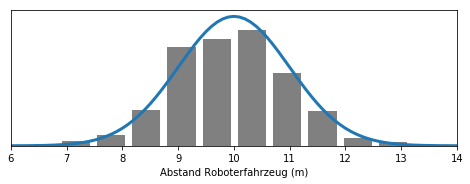

In [4]:
np.random.seed(12) # get allways same random number sequence
xs = range(500)
ys = np.random.randn(500)*1. + 10.
fig, ax = plt.subplots(figsize=(8,2.5))
ax.hist(ys, histtype='bar', color='grey', rwidth=0.8)
ax.plot(x,330*pdf_gauss, lw='3')
ax.set_xlabel('Abstand Roboterfahrzeug (m)')
ax.set_xlim(6,14)
ax.set_yticks([], [])

Folgende Tabelle fasst zusammen, wie die Histogramme des Bayes-Filters durch Gaußverteilungen des Kalman-Filters ersetzt werden:

$$\begin{array}{l|l|c}
\text{Bayes-Filter} & \text{Kalman-Filter} & \text{Iterationsschritt}\\
\hline
\bar {\mathbf x} = \mathbf x \ast f_x & 
\bar {x}_\mathcal{N} =  x_\mathcal{N} \, \oplus \, f_{x_\mathcal{N}} &
\text{Vorhersage} \\
\mathbf x = \|\mathcal L \circ \bar{\mathbf x}\| & x_\mathcal{N} = L \, \otimes \, \bar{x}_\mathcal{N} & \text{Korrektur} 
\end{array}$$

Die beiden Operatoren $\oplus$ und $\otimes$ sind Platzhalter und stehen für noch unbekannte Recheoperationen mit Gaußverteilungen. Der Index ${}_\mathcal{N}$ bei $x_\mathcal{N}$ soll daran erinnern, dass es sich hier um Gaußverteilungen handelt.

In den folgenden beiden Abschnitten wird nun gezeigt, dass einfache Additionen bzw. Multiplikationen für die noch unbekannten Operatoren $\oplus$ und $\otimes$ verwendet werden können.

## Vorhersage mit Gaußverteilung

Als physikalische Modell im Hintergund (Prozessmodell) wird eine gelichförmige Bewegung mit der Geschwindigkeit $v_k$ gewählt. Somit gilt für den Vorhersagewert:

$$ \begin{aligned}\bar{x}_k &= \hat{x}_{k-1} + v_k \Delta t \\
 &= \hat{x}_{k-1} + f_x\end{aligned}$$

Die Propagationsfunktion $f_x$ ist also hier lediglich $v_k \Delta t$. Sie berechnet die zurück gelegte Strecke während der Zeit $\Delta t$. 

**Beispiel:** Angenommen, es gibt keine Unsicherheiten in der Position oder in der Geschwindigkeit des Fahrzeugs. Das Fahrzeug sei an der Position 10 m und habe die Geschwindigkeit  15 m/s. Nach einer Zeit $\Delta t$ = 1 s errechnet sich die neue Fahrzeugposition zu:

$$ \begin{aligned} f_x &= v\Delta t = 15\cdot 1\\
\bar{x}_k &= 10 + (15\cdot 1) = 25 \end{aligned}$$

Die Herausforderung ist es jetzt, in die Mathematik die Unsicherheit der aktuellen Position und die Unsicherheit der Geschwindigkeit einfließen zu lassen.  
Angenommen, die aktuelle Position 10 m ist mit einer Unsicherheit von 0,2 m (68 % Vertrauensniveau) bekannt. Dann kann die Position einfach als Gaußverteilung $x=\mathcal N(10, 0.2^2)$ angegeben werden. Sozusagen "All Inclusive".  

Es ist naheliegend, auch **die Geschwindigkeit als Gaußverteilung anzunehmen und diese für eine Vorhersage auf die Gaußverteilung der Position auf zu addieren**. Die Mathematik dahinter ist die selbe, wie beispielsweise die der Fehlerfortpflanung bei der Addition zweier rauschbehafteter Ströme. Dieses Vorgehen macht also Sinn.   

Angenommen, die Geschwindigkeit besitzt eine Unsicherheit von 0.7 m/s (68 % Vertrauensniveau), d.h. $f_x = \mathcal N (15, 0.7^2)$. Dann gilt für den Vorhersagewert $\bar{x}_k$:

$$\bar{x}_k = \hat{x}_{k-1} + \Delta t f_x = \mathcal N(10, 0.2^2) + \Delta t \mathcal N (15, 0.7^2)$$

Der Einfachheit halber wird wieder angenommen $\Delta t = 1$, wodurch sich die obige Gleichung vereinfacht auf:

$$\bar{x}_k = \hat{x}_{k-1} + f_x = \mathcal N(10, 0.2^2) + \mathcal N (15, 0.7^2)$$

Auf der rechten Seite der Gleichung oben steht eine Addition zweier Gaußverteilung. Also ist auch die linke Seite wieder eine Gaußverteilung! 
> Die Vorhersage entspricht einer Addition einer Gaußverteilung. Damit ist der Vorhersagewert wieder eine Gaußverteilung. Weitere Iterationsschritte müssen ebenfalls wieder Gaußverteilungen als Ergebnis liefern. Nur dann ist eine stabile Filteriteration möglich, denn die Berechnungen basieren auf Gauß-Wahrscheinlichkeiten.

Allgemein gilt für den Erwartungswert und die Varianz der Summe aus zwei Gaußverteilungen:

$$\mu = \mu_1 + \mu_2  \qquad  \sigma^2 = \sigma^2_1 + \sigma^2_2$$

Wie erwartet wird die Varianz durch die Vorhersage etwas größer - genau so wie die Streubreite des Bayes-Filters durch die Faltung. In dem hier betrachteten Beispiel gilt also konkret:


$$\bar x = \mu_{\hat x} + \mu_{f_x} = 10 + 15 = 25 \qquad \bar\sigma^2 = \sigma_{\hat x}^2 + \sigma_{f_x}^2 = 0.2^2 + 0.7^2 = 0.53$$

Für die Gaußverteilungen $X \sim \mathcal N (\mu,\sigma^2)$ wird nachfolgend ein "Named Tuple" mit der Bezeichnung ``gaussian``  in Python definiert, um später einfacher mit solchen Werten rechnen zu können.

In [5]:
from collections import namedtuple
gaussian = namedtuple('Gaussverteilung', ['mean', 'var'])
gaussian.__repr__ = lambda s: '𝒩(μ={:.3f}, 𝜎²={:.3f})'.format(s[0], s[1])

Die Vorhersagefunktion ``predict()`` besitzt die Variablen ``pos`` und ``movement`` als Übergabewerte. Beide sind Gaußverteilungen und werden als Tupel ``gaussian`` in der Form ($\mu$, $\sigma^2$) angegeben.  
``predict()`` addiert sowohl den Erwartungswert als auch die Varianz der beiden Eingangsverteilungen und gibt dies als Ausgangsverteilung zurück. Diese Funktion führt also den Vohrhersageschritt als Addition der beiden Gauß-Verteilungen wie oben beschrieben aus.

In [6]:
def predict(pos, movement):
    return gaussian(pos.mean + movement.mean, pos.var + movement.var)

Nachfolgend ein kurzer Test der neuen Funktion mit den Gaußverteilungen für die akteulle Position und die Geschwinkdigkeit des Fahrzeugs  $\mathcal N(10, 0.2^2)$ bzw. $\mathcal N (15, 0.7^2)$.

In [7]:
pos = gaussian(10., .2**2)
move = gaussian(15., .7**2)
predict(pos, move)

𝒩(μ=25.000, 𝜎²=0.530)

Der Erwartungswert der Position hat sich wie erwartet um 15 auf 25 m erhöht. Die Varianz ist ebenfalls wie erwartet leicht angestiegen.

## Korrektur mit Gaußverteilung

Der diskrete Bayes-Filter verwendet Histogramme, um eine Positionsannahme des Roboterfahrzeugs auszudrücken. Die im Histogramm hinterlegte Verteilung ist diskret und eventuell multimodal.  
Nun wird von einer unimodalen Verteilung ausgegangen, da die Sensoren Messwerte liefern die gaußverteilt sind. Somit werden die Histogramme ebenfalls näherungsweise eine Gaußfunktion als Hüllkurve besitzen.  
**Die Bayes-Histogramme werden also durch Gaußverteilungen ersetzt.** Nun bleibt noch die Frage, wie mit diesen Gaußverteilungen der Korrekturschritt durchgeführt werden kann.  

Im Fall der Histogramme beim Bayes-Filter wurde für den Korrekturschritt als folgender Python-Code implementiert:

```python
def update(likelihood, prior):
    posterior = likelihood * prior
    return normalize(posterior)
```

Mathematisch ausgedrückt war der Korrekturschritt des Bayes-Filters eine elementweise Multiplikation des Vektors der Aufenthaltswahrscheinlichkeit (Vorhersagewert) mit dem Vektor der Likelyhood.

$$x = \| \mathcal L \circ \bar x \|$$

Der Vorhersagewert $\bar x$ liegt schon als Gaußverteilung aus dem vorherigen Abschnitt vor. In der Likelyhood $\mathcal L$ steckte beim Bayes-Filter die Information des Sensormesswerts.  
Die statistische Messunsicherheit des Sensors ist nun aber gaußförmig. Also liegt es nahe, das Messergebnis $z$ des Sensors auch mit einer Gaußverteilung auszudrücken.  
**Beispiel:** $z = \mathcal N (24, 0.16)$.
Dies bedeutet: Es liegt ein Messwert von 24 m vor mit einer Unsicherheit von 0,4 m bezogen auf ein Vertrauensniveau von 68 %.
Nun liegen sowohl der Vorhersagewert $\bar x$ als auch der Messwert $z$ als Gaußverteilungen vor. Es fehlt nur noch die Rechenvorschrift, wie aus diesen beiden Verteilungen der Korrekturwert $\hat x$ berechnet wird.  

Im Notebook zur Gauß-Wahrscheinlichkeitsverteilung wurde dargestellt, dass das Produkt zweier Gaußverteilungen wieder (bis auf die Normierung) eine Gaußverteilung liefert:   

$$\begin{aligned}
\mu &= \frac{\sigma_1^2 \mu_2 + \sigma_2^2 \mu_1} {\sigma_1^2 + \sigma_2^2}, \\
\sigma^2 &= \frac{\sigma_1^2\sigma_2^2}{\sigma_1^2+\sigma_2^2}
\end{aligned}$$

Ein genauer Blick auf die Formeln oben zeigt: Die Varianz des Produkts berechnet sich nur aus den Varianzen der Faktoren. Sie ist kleiner als jede der beiden Eingangsvarianzen. Die Erwartungswerte haben darauf keinen Einfluss.  
Der Erwartungswert des Produkts ist ein über die Varianzen gewichteter Mittelwert der Erwartungswerte der beiden Faktoren.  

>Die Multiplikation der beiden Gaußverteilungen "Vorhersagewert" und "Messwert" macht also genau das, was im Bayes-Filter die Multiplikation $\| \mathcal L \circ \bar x \|$ bewerkstelligte: Es wird ein Korrekturwert damit berechnet, der zwischen dem Vorhersagewert und Messwert liegt und eine kleinere Unsicherheit als jeweils der Vorhersagewert und Messwert alleine besitzt.

Die Mathematik des Korrekturschritts für Gaußverteilungen lässt sich also wie folgt formulieren:  

$$\begin{aligned}
\mathcal N(\hat \mu, \hat \sigma^2) &=\mathcal{N}(\bar\mu, \bar\sigma^2) \times \mathcal{N}(\mu_z, \sigma_z^2) \\
&= \mathcal N(\frac{\bar\sigma^2 \mu_z + \sigma_z^2 \bar\mu}{\bar\sigma^2 + \sigma_z^2},\frac{\bar\sigma^2\sigma_z^2}{\bar\sigma^2 + \sigma_z^2})
\end{aligned}$$

Das Multiplikationszeichen $\times$ soll andeuten, dass es sich hier um ein Produkt (also eine Kombination) von Wahrscheinlichkeiten handelt. Das rechnerische Produkt der beiden Gauß-Verteilungen muss daher noch normiert werden. Diese Normierung geschieht in der nächsten Zeile dadurch, dass die entsprechenden Werte für $\mu$ und $\sigma$ eingesetzt werden.  
Diese Rechenvorschrift wird nun in der Funktion ``gaussian_multiply()`` implementiert, womit wiederum eine Funktion ``update()`` erstellt wird, die den Korrekturschritt durchführt.

In [8]:
def gaussian_multiply(g1, g2):
    mean = (g1.var * g2.mean + g2.var * g1.mean) / (g1.var + g2.var)
    variance = (g1.var * g2.var) / (g1.var + g2.var)
    return gaussian(mean, variance)

def update(prior, likelyhood):
    posterior = gaussian_multiply(likelyhood, prior)
    return posterior

pos = gaussian(25., 0.350) # prior
meas = gaussian(24, 0.16) # measurement

update(pos, meas)

𝒩(μ=24.314, 𝜎²=0.110)

Der Test der Funktion ``update()`` am Ende des Codes oben zeigt, dass die Gaußverteilung des Korrekturwerts eine kleinere Varianz als der Messwert bzw. Vorhersagewert hat. Der Erwartungswert des Korrekturwerts liegt etwa doppelt so nah am Messwert wie am Vorhersagewert. Dies macht Sinn, denn die Varianz des Vorhersagewerts war auch etwa doppelt so groß wie die des Messwerts.

Der Algorithmus der Funktion ``update()`` hat die Aufgabe aus einer Wahrscheinlichkeitsverteilung und einer Messwertverteilung eine neue Wahscheinlichkeitsverteilung für die Zustandsgröße zu berechnen. Wie schon angesprochen liefert die Multiplikation zweier Gaußverteilungen und eine anschließende Normierung ein plausibles Ergebnis. Zudem ist die neue Wahrscheinlichkeitsverteilung wieder eine Gaußverteilung, wodurch dieser Schritt genau so wie der Vorhersageschritt im späteren Kalman-Filter iterativ angewendet werden kann.  

Es bleibt aber noch offen zu beweisen, dass die Multiplikation der beiden Gaußverteilungen tatsächlich die statistisch richtige, also wahrscheinlichste Verteilung der Zustandsgröße ergibt. Mathematische Beweise sind jedoch langweilig und für eine Anwendung der Mathematik nicht zwingend nötig. Daher ist es besser, diesen Sachverhalt intuitiv nachvollziehen zu können, womit sich der folgende Abschnitt befasst.

### Multiplikation von Gaußverteilungen als Korrekturschritt
Dieser Abschnitts hat das Ziel Folgendes ohne formalen mathematischen Beweis zu zeigen:  
> Es liegen zwei Wahrscheinlichkeitsverteilungen einer Zustandsgröße (hier der Abstand) vor. Die erste Verteilung ist die aktuelle Annahme der Zustandsgröße (hier der Vorhersagewert aufgrund des physikalischen Modells), die zweite Verteilung ist der Messwert der Zustandsgröße (hier der Messwert des Abstandssensors). Die normierte Multiplikation beider Verteilungen ist  die wahrscheinlichste Verteilung der Zustandsgröße.  

#### Vorhersagewert und Messwert stimmen überein
Angenommen, der Vorhersagewert stimmt mit dem Messwert überein. Der Korrekturwert berechnet sich dann aus $\mathcal{N}(10,\, 1) \times \mathcal{N}(10,\, 1)$. Folgender Plot zeigt sowohl die deckungslgleiche Verteilung von Vorhersagewert und Messwert als auch die Verteilung des Korrekturwerts:

𝒩(μ=10.000, 𝜎²=0.500)


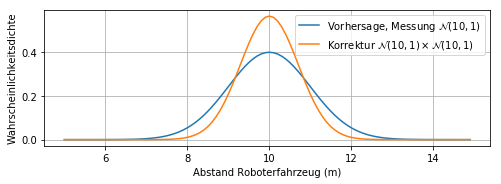

In [9]:
z = gaussian(10., 1.)  # Gaussian N(10, 1)
prior = gaussian(10., 1.)
posterior = gaussian_multiply(z, z)

x = np.arange(5,15,0.1)
pdf_prior = norm.pdf(x,prior.mean,np.sqrt(prior.var))
pdf_posterior = norm.pdf(x,posterior.mean,np.sqrt(posterior.var))

fig, ax = plt.subplots(figsize=(8,2.5))
ax.plot(x,pdf_prior,label='Vorhersage, Messung $\mathcal{N}(10,1)$')
ax.plot(x,pdf_posterior,label='Korrektur $\mathcal{N}(10,1) \\times \mathcal{N}(10,1)$')
ax.set_xlabel('Abstand Roboterfahrzeug (m)')
ax.set_ylabel('Wahrscheinlichkeitsdichte')
ax.legend()
ax.grid()

print(posterior)

Der Erwartungswert ist wie erwartet gleich geblieben. Die Varianz hat sich halbiert: Die Varianz eines Mittelwerts sinkt mit 1/N, wobei N für die Stichprobengröße steht. Der Korrekturwert lässt sich als Mittelwert aus dem Vorhersagewert und dem Messwert auffassen. Daher macht auch die Halbierung der Varianz im Beispiel oben Sinn.

#### Vorhersagewert und Messwert mit gleicher Varianz aber abweichendem Erwartungswert
Der nächste Plot betrachtet die Situation, dass der Vorhersagewert $\mathcal{N}(8,\, 1)$ und der Messwert $\mathcal{N}(12,\, 1)$ einen unterschiedlichen Erwartungswert aber die gleiche Varianz besitzen. Wie erwartet liegt der Korrekturwert genau in der Mitte, denn beide Eingangsverteilungen besitzen die gleiche Unsicherheit. Die Varianz des Korrekturwerts hat sich auch hier aus dem selben Grund wie im Beispiel oben halbiert.

𝒩(μ=10.000, 𝜎²=0.500)


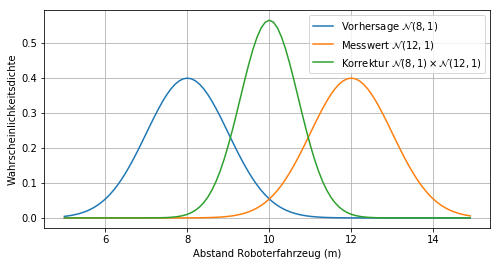

In [10]:
z = gaussian(12, 1)  # Gaussian N(10, 1)
prior = gaussian(8, 1)

posterior = gaussian_multiply(prior, z)

x = np.arange(5,15,0.1)
pdf_prior = norm.pdf(x,prior.mean,np.sqrt(prior.var))
pdf_z = norm.pdf(x,z.mean,np.sqrt(z.var))
pdf_posterior = norm.pdf(x,posterior.mean,np.sqrt(posterior.var))

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(x,pdf_prior,label='Vorhersage $\mathcal{N}(8,1)$')
ax.plot(x,pdf_z,label='Messwert $\mathcal{N}(12,1)$')
ax.plot(x,pdf_posterior,label='Korrektur $\mathcal{N}(8,1) \\times \mathcal{N}(12,1)$')
ax.set_xlabel('Abstand Roboterfahrzeug (m)')
ax.set_ylabel('Wahrscheinlichkeitsdichte')
ax.legend()
ax.grid()

print(posterior)

### Vorhersagewert und Messwert mit und unterschiedlichem Erwartungswert und deutlich unterschiedlicher Varianz

Die Multiplikation der beiden Gaußverteilungen liefert also ein entsprechendes Ergebnis wie der g-h-Filter: Der Korrekturwert liegt zwischen dem Vorhersagewert und dem Messwert. Ob er näher am Messwert oder näher am Vorhersagewert liegt, wird hier im Fall der Gaußverteilung über das Verhältnis der beiden Varianzen bestimmt.    
Dies wird im nachfolgenden Plot verdeutlicht: Die Vorhersage und der Messwert besitzen die selben unterschiedlichen Erwartungswerte wie im Plot oben, haben jedoch jetzt eine deutlich unterschiedliche Unsicherheit (Varianz).  
Der Korrekturwert ist der nach den beiden Varianzen gewichtete Mittelwert aus der Vorhersage und der Messung. Da die Varianz der Vorhersage dreimal kleiner ist als die der Messung, liegt der Korrekturwert auch dreimal näher am Vorhersagewert als an dem Messwert.

𝒩(μ=9.000, 𝜎²=0.375)


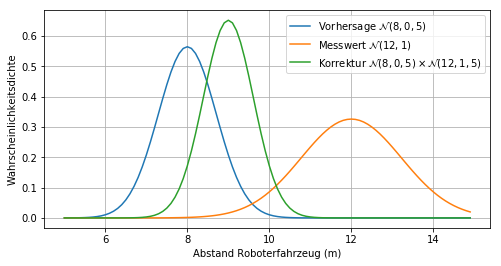

In [11]:
z = gaussian(12, 1.5)  # Gaussian N(10, 1)
prior = gaussian(8, 0.5)

posterior = gaussian_multiply(prior, z)

x = np.arange(5,15,0.1)
pdf_prior = norm.pdf(x,prior.mean,np.sqrt(prior.var))
pdf_z = norm.pdf(x,z.mean,np.sqrt(z.var))
pdf_posterior = norm.pdf(x,posterior.mean,np.sqrt(posterior.var))

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(x,pdf_prior,label='Vorhersage $\mathcal{N}(8,0,5)$')
ax.plot(x,pdf_z,label='Messwert $\mathcal{N}(12,1)$')
ax.plot(x,pdf_posterior,label='Korrektur $\mathcal{N}(8,0,5) \\times \mathcal{N}(12,1,5)$')
ax.set_xlabel('Abstand Roboterfahrzeug (m)')
ax.set_ylabel('Wahrscheinlichkeitsdichte')
ax.legend()
ax.grid()

print(posterior)

### Fazit
Die Iteration aus einem Vorhersageschritt und einem Korrekturschritt, wie sie im Notebook für den g-h-Filter und anschließend für den Bayes-Filter entwickelt wurde, kann auf gaußförmige Wahrscheinlichkeitsverteilungen übertragen werden. Dabei vereinfacht sich die Mathematik erheblich, denn die Vorhersage entspricht einer Addition und die Korrektur einer Multiplikation von Gaußfunktionen.